## Use case: aggregating current API information and general information about repositories

“As a research data portal, it is important for us to know which repositories offer an API. We would like to aggregate API information, such as API endpoint, API type and general information about the repository.”

### Step 1: load packages

The package **httr** includes the HTTP method GET, which will be used to request data from the re3data API. Responses from the re3data API are returned in XML. **xml2** includes functions for working with XML, for example parsing or extracting content of specific elements. **dplyr** offers useful functions for data manipulation. **ggplot2** is a package for data visualization.

If necessary, install the packages before loading them.

In [9]:
#install.packages("htttr")
#install.packages("xml2")
#install.packages("dplyr")
#install.packages("ggplot2")
library(httr)
library(xml2)
library(dplyr)
library(ggplot2)

### Step 2: obtain URLs for further API queries

Information on individual repositories can be extracted using the re3data ID. Therefore, re3data IDs of all repositories indexed in re3data need to be identified first, using the endpoint **/api/v1/repositories**. Details of the re3data APIs are outlined in the [re3data API documentation](https://www.re3data.org/api/doc).

The endpoint is queried using **GET**. The XML response is parsed using **read_XML**. XML elements or attributes can be identified using XPath syntax. All elements matching the XPath syntax for finding re3data IDs are identified with **xml_find_all**, and their content is extracted using **xml_text**. The three functions are nested in the example below.

The endpoint **/api/v1/repository** provides detailed information about individual repositories that can be accessed via re3data IDs. Therefore, URLs for the next query are created by adding re3data IDs to the base URL.

In [10]:
re3data_request <- GET("http://re3data.org/api/v1/repositories")
re3data_IDs <- xml_text(xml_find_all(read_xml(re3data_request), xpath = "//id"))
URLs <- paste("https://www.re3data.org/api/v1/repository/", re3data_IDs, sep = "")

### Step 3: define what information about the repositories should be requested

The function **extract\_repository\_info** defined in the following code block points to and extracts the content of specific XML elements and attributes. This function will be used later to extract the specified information from responses of the re3data API. Its basic structure is similar to the process of extracting the URLs outlined in step 2 above.

In our Metadata schema, **api** (the API endpoint) is an element with the attribute **apiType**. Please note that one repository can offer multiple APIs, and even several API types.

The XPath expressions defined here will extract the re3data IDs, names, URLs, API endpoints and API types in their specific order (using the parameter *API_index*). Results are stored in a named list that can be processed later. Depending on specific use cases, this function can be adapted to extract a different set of elements and attributes. For an overview of the metadata re3data offers, please refer to the documentation of the [re3data Metadata Schema](https://doi.org/10.2312/re3.006) (the API uses version 2.2 of the re3data Metadata Schema).

The function **xml_structure** from the package **xml2** can be very useful for inspecting the structure of XML objects and specifying XPath expressions.

In [11]:
extract_repository_info <- function(url, API_index) {
  list(
   re3data_ID = xml_text(xml_find_all(repository_metadata_XML, "//r3d:re3data.orgIdentifier")),
    repositoryName = xml_text(xml_find_all(repository_metadata_XML, "//r3d:repositoryName")),
    repositoryUrl = xml_text(xml_find_all(repository_metadata_XML, "//r3d:repositoryURL")),
    api = paste(unique(xml_text(xml_find_all(repository_metadata_XML,paste0("//r3d:api", "[", as.character(API_index), "]"))))),
    apiType = paste(unique(xml_text(xml_find_all(repository_metadata_XML,paste0("//r3d:api", "[", as.character(API_index), "]", "/@apiType")))))
  )
}

### Step 4: create a container for storing results

**repository_info** is a container for storing results of the API query. The dataframe has five columns corresponding to names of the list items defined by **extract_repository_info**.

In [12]:
repository_info <- data.frame(matrix(ncol = 5, nrow = 0))

colnames(repository_info) <- c("re3data_ID", "repositoryName", "repositoryUrl", "api", "apiType")

### Step 5: gather detailed information about repositories

After preparing the list of URLs, the extracting function and the container for results, these components can be put together. The code block below iterates through the list of URLs using a for-loop. For each repository, data is requested from the re3data API using **GET**. The XML response is parsed with **read_xml**. An Xpath expression is used to count how often the element *api* occurs for each repository. If *APICount* is larger than 0, the function **extract_repository_info** is called. The results are then appended as a new row to **repository_info**.

In [13]:
for (url in URLs) {
  repository_metadata_request <- GET(url)
  repository_metadata_XML <-read_xml(repository_metadata_request) 
  API_count <- length(paste(unique(xml_text(xml_find_all(repository_metadata_XML, "//r3d:api")))))
  if(API_count > 0){
    for(i in c(1:API_count)){
      results_list <- extract_repository_info(repository_metadata_XML, i)
      repository_info <- rbind(repository_info, results_list)    
    }}else next
  
}

### Step 6: Look at the results

Results are now stored in **repository_info**. They can be inspected using **head** or visualized.

The example below first groups data by **apiType** and counts how many repositories are in each group, then orders **apiType** by occurrence in descending order. Then, a bar chart of APIs offered by repositories indexed in re3data is generated.
Please note that, as mentioned above, **apiType** has an occurrence of 1-n. Some repositories are assigned more than one API type, for example REST and OAI-PMH.

,re3data_ID,repositoryName,repositoryUrl,api,apiType
,<chr>,<chr>,<chr>,<chr>,<chr>
1,r3d100000002,Access to Archival Databases,https://aad.archives.gov/aad/,https://www.archives.gov/developer#toc-application-programming-interfaces-apis-,other
2,r3d100000005,UNC Dataverse,https://dataverse.unc.edu/,https://guides.dataverse.org/en/latest/api/native-api.html,REST
3,r3d100000005,UNC Dataverse,https://dataverse.unc.edu/,https://guides.dataverse.org/en/latest/api/sword.html,SWORD
4,r3d100000006,Archaeology Data Service,https://archaeologydataservice.ac.uk/,https://archaeologydataservice.ac.uk/about/endpoints.xhtml,OAI-PMH
5,r3d100000006,Archaeology Data Service,https://archaeologydataservice.ac.uk/,http://data.archaeologydataservice.ac.uk/query/,SPARQL
6,r3d100000011,The CEDA Archive,http://archive.ceda.ac.uk/,https://help.ceda.ac.uk/article/280-ftp,FTP


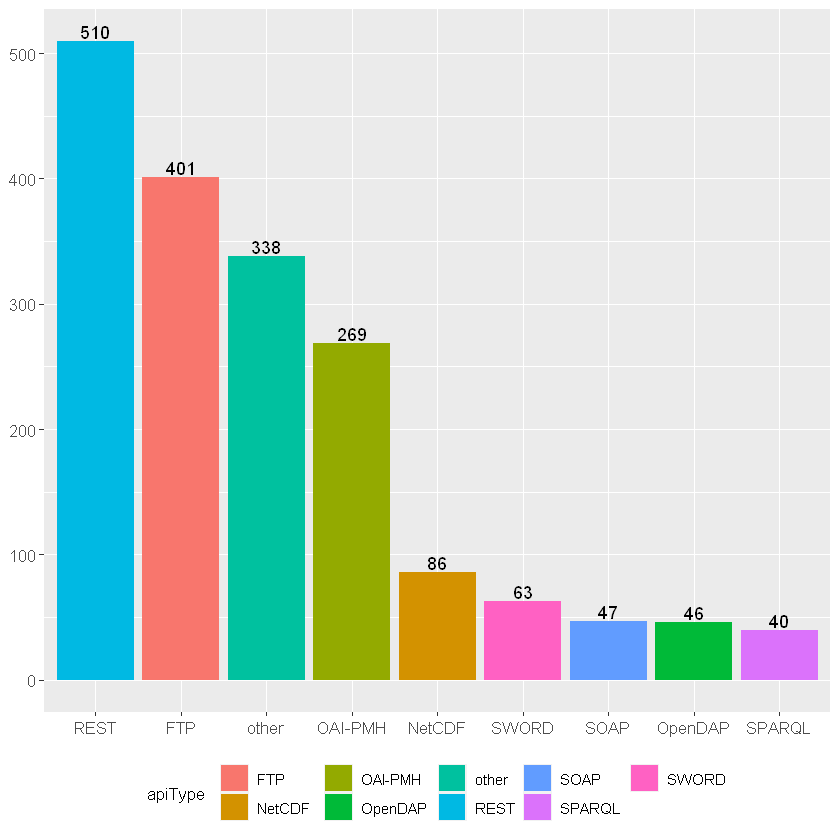

In [14]:
head(repository_info)

repository_info %>%
  group_by(apiType) %>%
  summarise(type_count = n()) %>%
  ggplot(aes(x = reorder(apiType, -type_count), y = type_count, fill = apiType)) +
  geom_col() +
  geom_text(aes(label = type_count), position = position_dodge(width = 1),vjust = -0.2)+
  theme(axis.title = element_blank(),
        axis.text = element_text(size = 10),
        legend.position = "bottom",
        legend.title = element_text(size = 10))